## What is a Feature Descriptor?
A feature descriptor is a representation of an image or an image patch that simplifies the image by extracting useful information and throwing away extraneous information.

Typically, a feature descriptor converts an image of size width x height x 3 (channels ) to a feature vector / array of length n. In the case of the HOG feature descriptor, the input image is of size 64 x 128 x 3 and the output feature vector is of length 3780.

Keep in mind that HOG descriptor can be calculated for other sizes, but in this experiment I am sticking to numbers presented in the original paper so you can easily understand the concept with one concrete example.

This all sounds good, but what is “useful” and what is “extraneous” ? To define “useful”, we need to know what is it “useful” for ? Clearly, the feature vector is not useful for the purpose of viewing the image. But, it is very useful for tasks like image recognition and object detection. The feature vector produced by these algorithms when fed into an image classification algorithms like Support Vector Machine (SVM) produce good results.

In the HOG feature descriptor, the distribution ( histograms ) of directions of gradients ( oriented gradients ) are used as features. Gradients ( x and y derivatives ) of an image are useful because the magnitude of gradients is large around edges and corners ( regions of abrupt intensity changes ) and we know that edges and corners pack in a lot more information about object shape than flat regions.

## Visualization

### 1. Load the image

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Read image
im = cv2.imread('./images/bolt.jpg')
im = np.float32(im) / 255.0


### 2. Pre-processed data
We need to preprocess the image and bring down the width to height ratio to 1:2. The image size should preferably be 64 x 128. This is because we will be dividing the image into 8*8 and 16*16 patches to extract the features. Having the specified size (64 x 128) will make all our calculations pretty simple. In fact, this is the exact value used in the original paper.

In [12]:
im = cv2.resize(im, (128,64))
print(im.shape)

(64, 128, 3)


### 3. Calculate Gradients

In [13]:
# Calculate gradient
gx = cv2.Sobel(im, cv2.CV_32F, 1, 0, ksize=1)
gy = cv2.Sobel(im, cv2.CV_32F, 0, 1, ksize=1)

In [14]:
# Python Calculate gradient magnitude and direction ( in degrees )
mag, angle = cv2.cartToPolar(gx, gy, angleInDegrees=True)
print("Magnitude: ", mag)
print("Angle: ", angle)

Magnitude:  [[[0.         0.         0.        ]
  [0.00148016 0.00600299 0.01020411]
  [0.00210053 0.00966415 0.01554647]
  ...
  [0.04152495 0.04250535 0.04201517]
  [0.03268033 0.0301145  0.03017771]
  [0.         0.         0.        ]]

 [[0.01828086 0.00665593 0.03276271]
  [0.01365673 0.0333588  0.06199279]
  [0.01368676 0.01533011 0.04348994]
  ...
  [0.0276264  0.02105001 0.02962969]
  [0.02317239 0.02241966 0.03446028]
  [0.01206726 0.02027419 0.03455308]]

 [[0.01176274 0.01517886 0.01897407]
  [0.0181399  0.01699834 0.02136367]
  [0.02394892 0.01813695 0.02741813]
  ...
  [0.01613551 0.02489357 0.04031408]
  [0.00407419 0.01352942 0.02008276]
  [0.00132501 0.01043963 0.02612591]]

 ...

 [[0.0294022  0.02598614 0.0328182 ]
  [0.01571499 0.03225386 0.0389594 ]
  [0.0247766  0.01621608 0.00744412]
  ...
  [0.04398979 0.02973093 0.03921237]
  [0.03886208 0.02891361 0.03904741]
  [0.06560963 0.06374463 0.05035043]]

 [[0.00499195 0.00352138 0.0072476 ]
  [0.03473734 0.02676627 

### 4. Plot gradients

Shape of image:  (64, 128, 3)
Shape of gx:  (64, 128, 3)
Shape of gy:  (64, 128, 3)
Shape of mag:  (64, 128, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


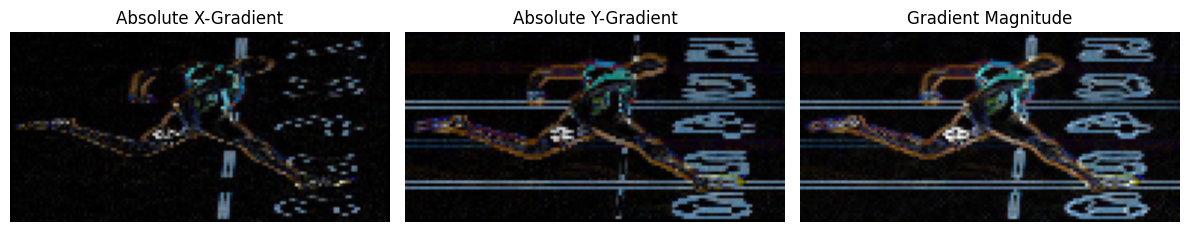

In [15]:
# Compute the absolute values for plotting
abs_gx = np.abs(gx)
abs_gy = np.abs(gy)
abs_mag = np.abs(mag)

print("Shape of image: ", im.shape)
print("Shape of gx: ", abs_gx.shape)
print("Shape of gy: ", abs_gy.shape)
print("Shape of mag: ", abs_mag.shape)

# Plot the results
plt.figure(figsize=(12, 4))

# X-gradient
plt.subplot(1, 3, 1)
plt.imshow(abs_gx, cmap='gray')
plt.title('Absolute X-Gradient')
plt.axis('off')

# Y-gradient
plt.subplot(1, 3, 2)
plt.imshow(abs_gy, cmap='gray')
plt.title('Absolute Y-Gradient')
plt.axis('off')

# Gradient Magnitude
plt.subplot(1, 3, 3)
plt.imshow(abs_mag, cmap='gray')
plt.title('Gradient Magnitude')
plt.axis('off')

plt.tight_layout()
plt.show()


Notice, the x-gradient fires on vertical lines and the y-gradient fires on horizontal lines. The magnitude of gradient fires where ever there is a sharp change in intensity. None of them fire when the region is smooth. I have deliberately left out the image showing the direction of gradient because direction shown as an image does not convey much.

The gradient image removed a lot of non-essential information ( e.g. constant colored background ), but highlighted outlines. In other words, you can look at the gradient image and still easily say there is a person in the picture.

At every pixel, the gradient has a magnitude and a direction. For color images, the gradients of the three channels are evaluated ( as shown in the figure above ). The magnitude of gradient at a pixel is the maximum of the magnitude of gradients of the three channels, and the angle is the angle corresponding to the maximum gradient.

### 5. Different Methods to Create Histograms using Gradients and Orientation
A histogram is a plot that shows the frequency distribution of a set of continuous data. We have the variable (in the form of bins) on the x-axis and the frequency on the y-axis. Here, we are going to take the angle or orientation on the x-axis and the frequency on the y-axis.

#### Method 1
Let us start with the simplest way to generate histograms. We will take each pixel value, find the orientation of the pixel and update the frequency table.

Here is the process for the highlighted pixel (85). Since the orientation for this pixel is 36, we will add a number against angle value 36, denoting the frequency:

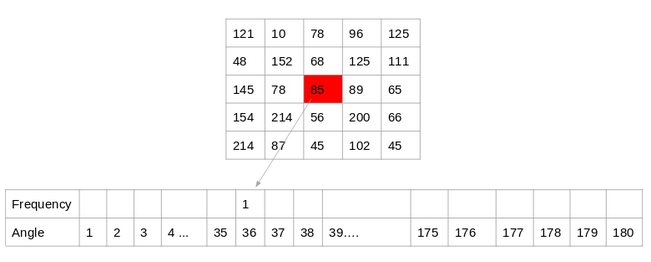  

The same process is repeated for all the pixel values, and we end up with a frequency table that denotes angles and the occurrence of these angles in the image. This frequency table can be used to generate a histogram with angle values on the x-axis and the frequency on the y-axis.

That’s one way to create a histogram. Note that here the bin value of the histogram is 1. Hence we get about 180 different buckets, each representing an orientation value. Another method is to create the histogram features for higher bin values.

#### Method 2:
This method is similar to the previous method, except that here we have a bin size of 20. So, the number of buckets we would get here is 9.

Again, for each pixel, we will check the orientation, and store the frequency of the orientation values in the form of a 9 x 1 matrix. Plotting this would give us the histogram:

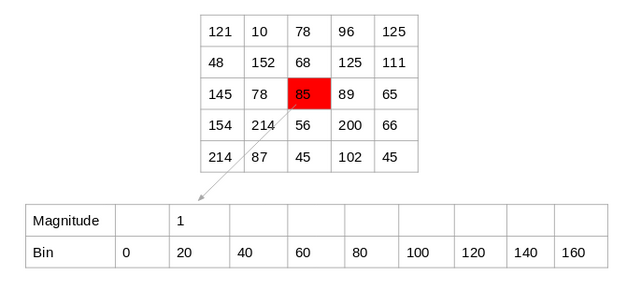  

#### Method 3:
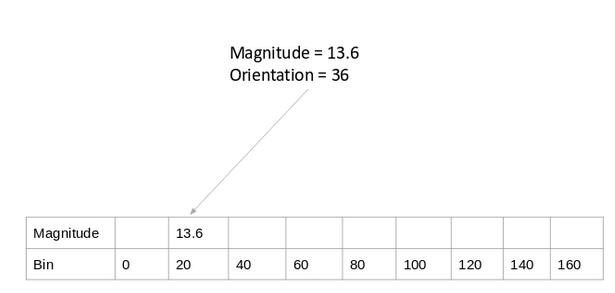  
The above two methods use only the orientation values to generate histograms and do not take the gradient value into account. Here is another way in which we can generate the histogram – instead of using the frequency, we can use the gradient magnitude to fill the values in the matrix. Below is an example of this:


You might have noticed that we are using the orientation value of 30, and updating the bin 20 only. Additionally, we should give some weight to the other bin as well.

#### Method 4:
Let’s make a small modification to the above method. Here, we will add the contribution of a pixel’s gradient to the bins on either side of the pixel gradient. Remember, the higher contribution should be to the bin value which is closer to the orientation.

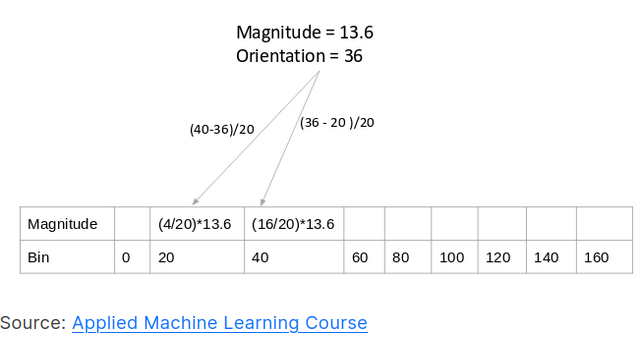  
This is exactly how histograms are created in the HOG feature descriptor.

### 6. Calculate Histogram of Gradients in 8×8 cells (9×1)
The histograms created in the HOG feature descriptor are not generated for the whole image. Instead, the image is divided into 8×8 cells, and the histogram of oriented gradients is computed for each cell. Why do you think this happens?

By doing so, we get the features (or histogram) for the smaller patches which in turn represent the whole image. We can certainly change this value here from 8 x 8 to 16 x 16 or 32 x 32.

If we divide the image into 8×8 cells and generate the histograms, we will get a 9 x 1 matrix for each cell. This matrix is generated using method 4 that we discussed in the previous section.

Once we have generated the HOG for the 8×8 patches in the image, the next step is to normalize the histogram.

### 7. Normalize gradients in 16×16 cell (36×1)
Before we understand how this is done, it’s important to understand why this is done in the first place.

Although we already have the HOG features created for the 8×8 cells of the image, the gradients of the image are sensitive to the overall lighting. This means that for a particular picture, some portion of the image would be very bright as compared to the other portions.

We cannot completely eliminate this from the image. But we can reduce this lighting variation by normalizing the gradients by taking 16×16 blocks. Here is an example that can explain how 16×16 blocks are created:

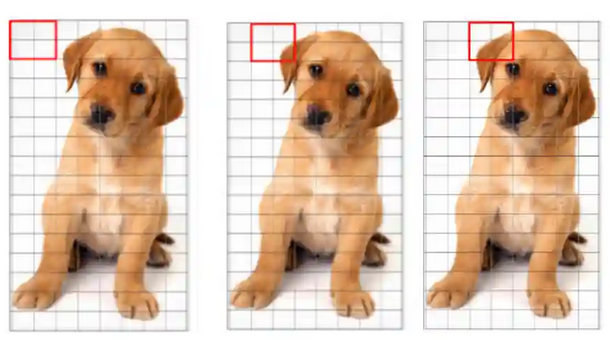
Here, we will be combining four 8×8 cells to create a 16×16 block. And we already know that each 8×8 cell has a 9×1 matrix for a histogram. So, we would have four 9×1 matrices or a single 36×1 matrix. To normalize this matrix, we will divide each of these values by the square root of the sum of squares of the values. Mathematically, for a given vector V:

V = [a1, a2, a3, ….a36]

We calculate the root of the sum of squares:

k = √(a1)2+ (a2)2+ (a3)2+ …. (a36)2

And divide all the values in the vector V with this value k:

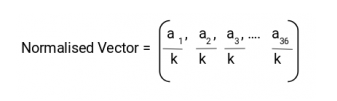

The resultant would be a normalized vector of size 36×1.

### 8. Features for the complete image
We are now at the final step of generating HOG features for the image. So far, we have created features for 16×16 blocks of the image. Now, we will combine all these to get the features for the final image.

Can you guess what would be the total number of features that we will have for the given image? We would first need to find out how many such 16×16 blocks would we get for a single 64×128 image:

We would have 105 (7×15) blocks of 16×16. Each of these 105 blocks has a vector of 36×1 as features. Hence, the total features for the image would be 105 x 36×1 = 3780 features.

We will now generate HOG features for a single image and verify if we get the same number of features at the end.

## Implementation

In [16]:
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure
import matplotlib.pyplot as plt
%matplotlib inline

(464, 417, 3)


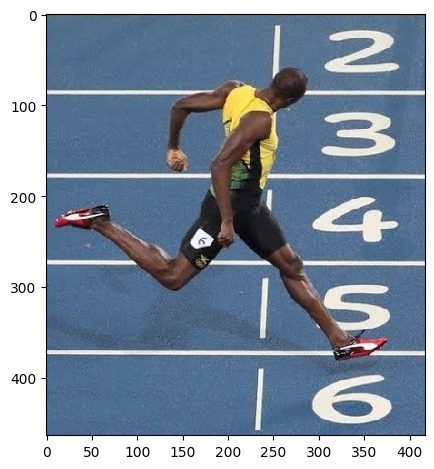

In [17]:
#reading the image
img = imread('./images/bolt.jpg')
imshow(img)
print(img.shape)

(128, 64, 3)


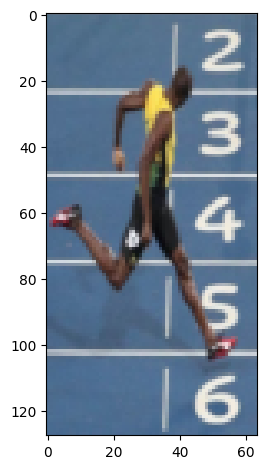

In [18]:
#resizing image 
resized_img = resize(img, (128,64)) 
imshow(resized_img) 
print(resized_img.shape)

Here, I am going to use the hog function from skimage.features directly. So we don’t have to calculate the gradients, magnitude (total gradient) and orientation individually. The hog function would internally calculate it and return the feature matrix.

Also, if you set the parameter `visualize = True`, it will return an image of the HOG.

In [22]:

#creating hog features 
fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8), 
                    cells_per_block=(2, 2), visualize=True, channel_axis=-1)


In [23]:
fd.shape

(3780,)

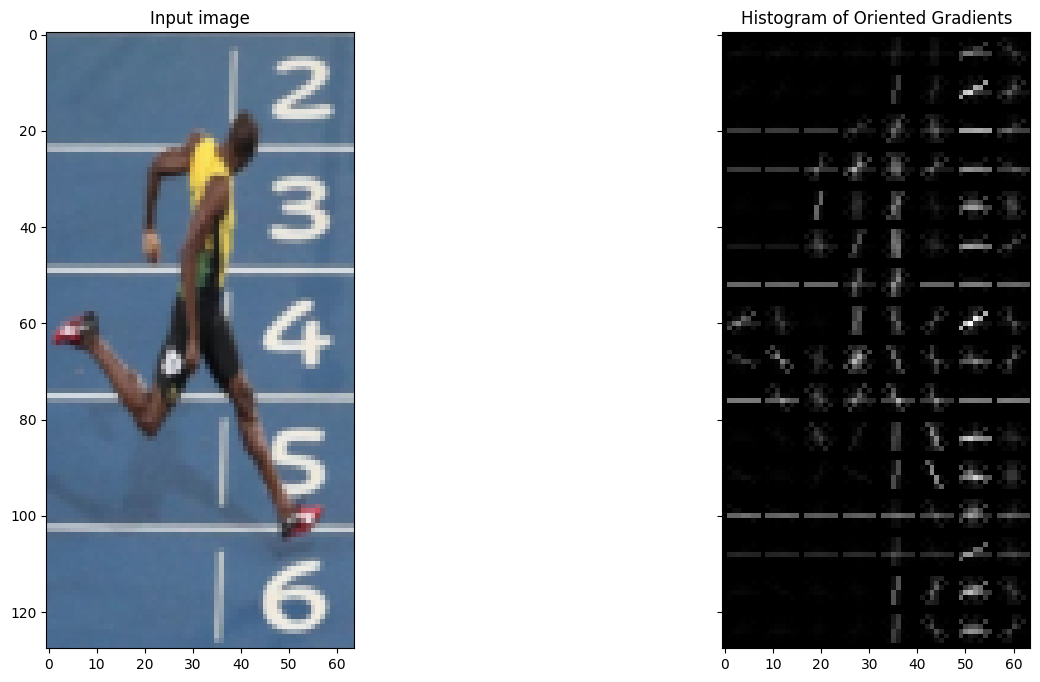

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True) 

ax1.imshow(resized_img, cmap=plt.cm.gray) 
ax1.set_title('Input image') 

# Rescale histogram for better display 
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10)) 

ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray) 
ax2.set_title('Histogram of Oriented Gradients')

plt.show()
